In [1]:
from __future__ import print_function, division
from keras.datasets import fashion_mnist

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers import ELU, PReLU, LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt

2023-12-25 14:40:28.402028: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(training_data, _), (_, _) = fashion_mnist.load_data()
X_train = training_data / 127.5 - 1.
X_train = np.expand_dims(X_train, axis=3)

4422102/4422102 [==============================] - 1s 0us/step


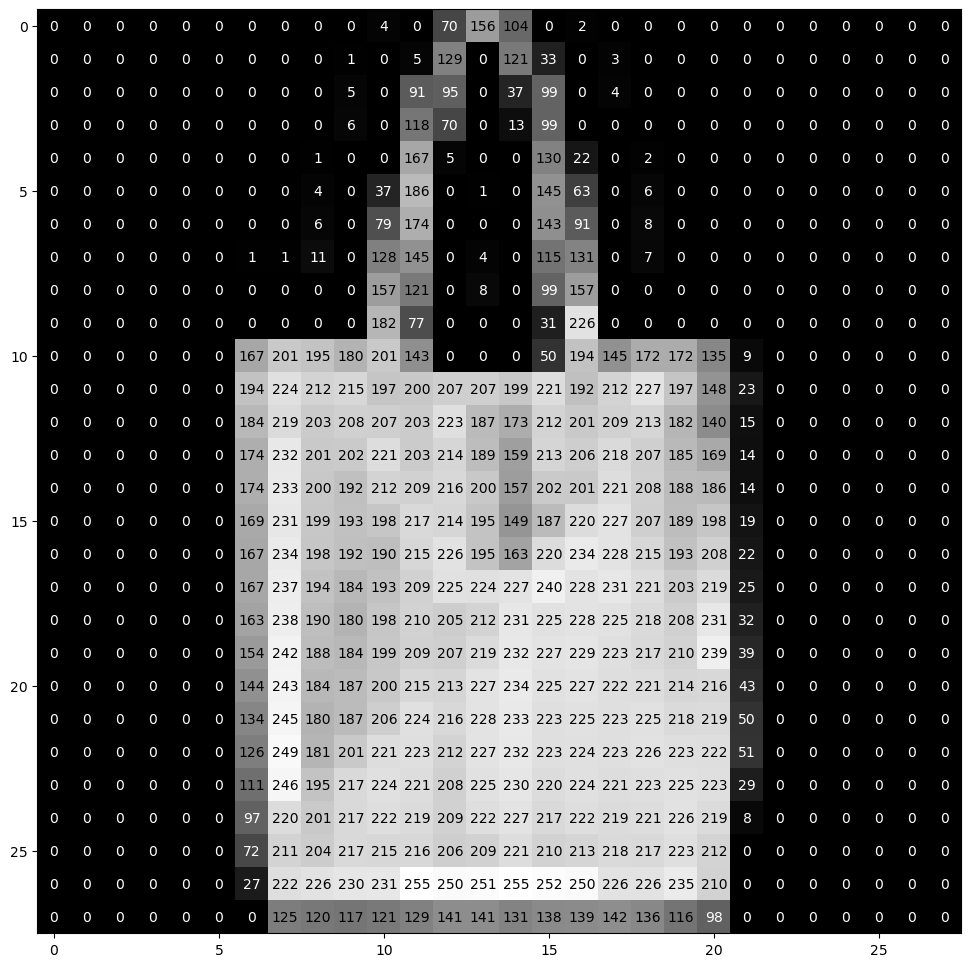

In [3]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')        
        
fig = plt.figure(figsize = (12,12))

ax = fig.add_subplot(111)
visualize_input(training_data[3343], ax)

In [8]:
def build_generator():
    generator = Sequential()

    generator.add(Dense(6272, activation="relu", input_dim=100))
    generator.add(Reshape((7, 7, 128)))
    generator.add(UpSampling2D())
    generator.add(Conv2D(128, kernel_size=3, padding="same", activation="relu"))
    generator.add(UpSampling2D())

    generator.add(Conv2D(64, kernel_size=3, padding="same", activation="relu"))
    generator.add(BatchNormalization(momentum=0.8))

    generator.add(Conv2D(1, kernel_size=3, padding="same", activation="relu"))
    generator.summary()

    noise = Input(shape=(100,)) 
    fake_img = generator(noise)

    return Model(noise, fake_img)


In [9]:
def build_discriminator():

  discriminator = Sequential()
  discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(28,28,1), padding="same"))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))
  
  discriminator.add(Conv2D(64, kernel_size=3, strides=2,padding="same"))
  discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
  discriminator.add(BatchNormalization(momentum=0.8))
  
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))
  
  discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))
  
  discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
  discriminator.add(BatchNormalization(momentum=0.8))
  discriminator.add(LeakyReLU(alpha=0.2))
  discriminator.add(Dropout(0.25))
  
  discriminator.add(Flatten())
  discriminator.add(Dense(1, activation='sigmoid'))
  
  img = Input(shape=(28,28,1))
  probability = discriminator(img)
 
  return Model(inputs=img, outputs=probability)

In [10]:
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
discriminator.trainable = False

# Build the generator
generator = build_generator()

z = Input(shape=(100,))
img = generator(z)

valid = discriminator(img)

combined = Model(inputs=z, outputs=valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

2023-12-25 14:49:42.283855: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 up_sampling2d_1 (UpSampling  (None, 28, 28, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)       

In [11]:
def plot_generated_images(epoch, generator, examples=100, dim=(10, 10),figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)
    
    plt.figure(figsize=figsize)

    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('gan_generated_image_epoch_%d.png' % epoch)

In [12]:
def train(epochs, batch_size=128, save_interval=50):
    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):  # Train Discriminator network
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        
        
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        g_loss = combined.train_on_batch(noise, valid)
        
        # printing progress
        print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(epoch, d_loss[0], 100*d_loss[1], g_loss))
        
        if epoch % save_interval == 0:
            plot_generated_images(epoch, generator)

In [13]:
# Input shape
img_shape = (28,28,1)
channels = 1
latent_dim = 100

optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              633472    
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_2 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 128)       147584    
                                                                 
 up_sampling2d_3 (UpSampling  (None, 28, 28, 128)      0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 28, 28, 64)       

2/2 [==============================] - 0s 42ms/step
0 [D loss: 0.000651, acc.: 100.00%] [G loss: 0.357492]
2/2 [==============================] - 0s 31ms/step
1 [D loss: 0.000889, acc.: 100.00%] [G loss: 0.419478]
2/2 [==============================] - 0s 36ms/step
2 [D loss: 0.001967, acc.: 100.00%] [G loss: 0.372152]
2/2 [==============================] - 0s 35ms/step
3 [D loss: 0.000808, acc.: 100.00%] [G loss: 0.356572]
2/2 [==============================] - 0s 36ms/step
4 [D loss: 0.000843, acc.: 100.00%] [G loss: 0.359831]
2/2 [==============================] - 0s 34ms/step
5 [D loss: 0.001384, acc.: 100.00%] [G loss: 0.378578]
2/2 [==============================] - 0s 33ms/step
6 [D loss: 0.000766, acc.: 100.00%] [G loss: 0.402798]
2/2 [==============================] - 0s 33ms/step
7 [D loss: 0.000739, acc.: 100.00%] [G loss: 0.338161]
2/2 [==============================] - 0s 33ms/step
8 [D loss: 0.000630, acc.: 100.00%] [G loss: 0.325207]
2/2 [==============================] 

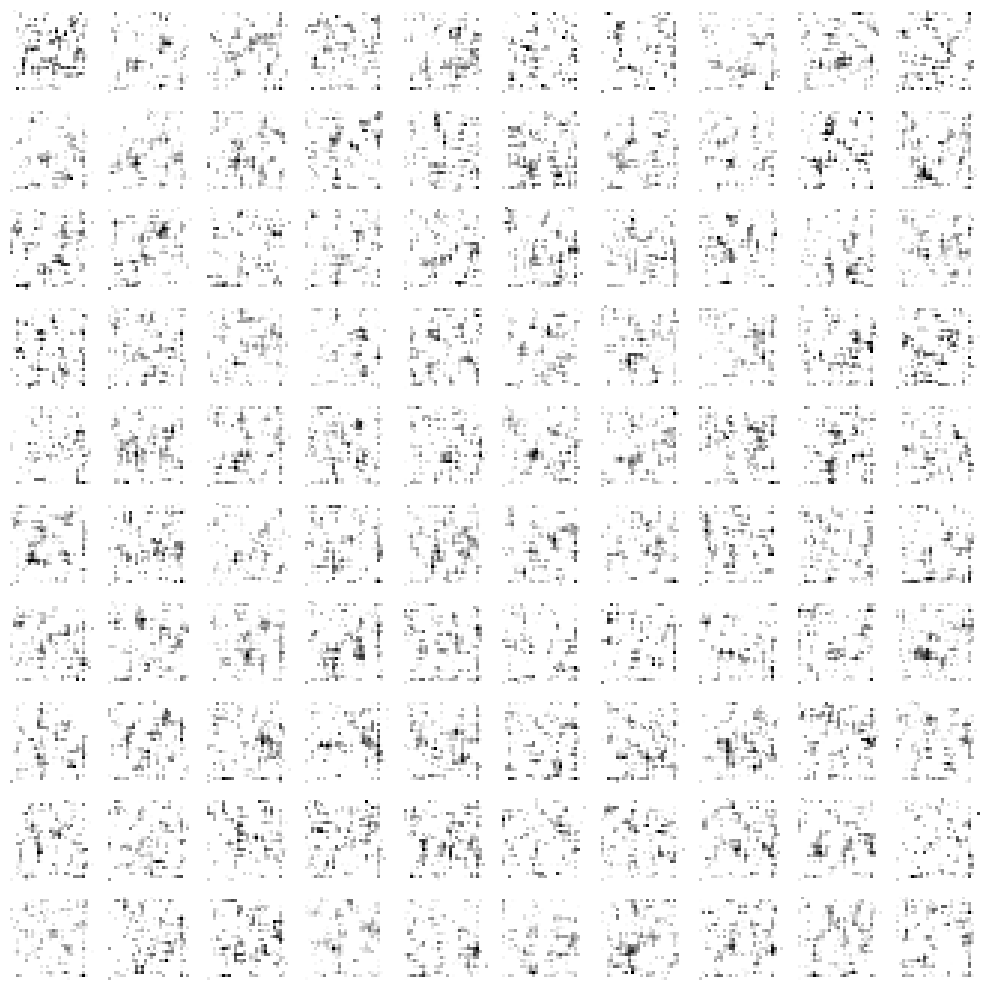

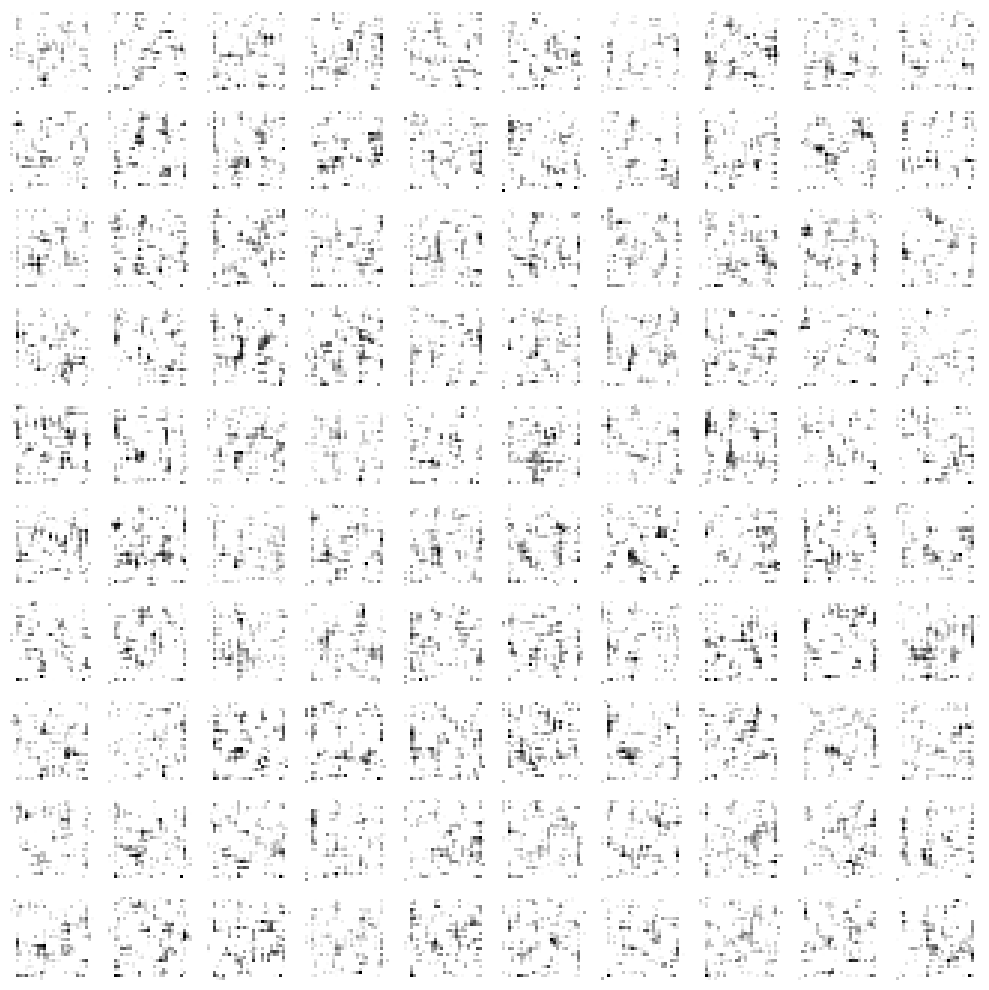

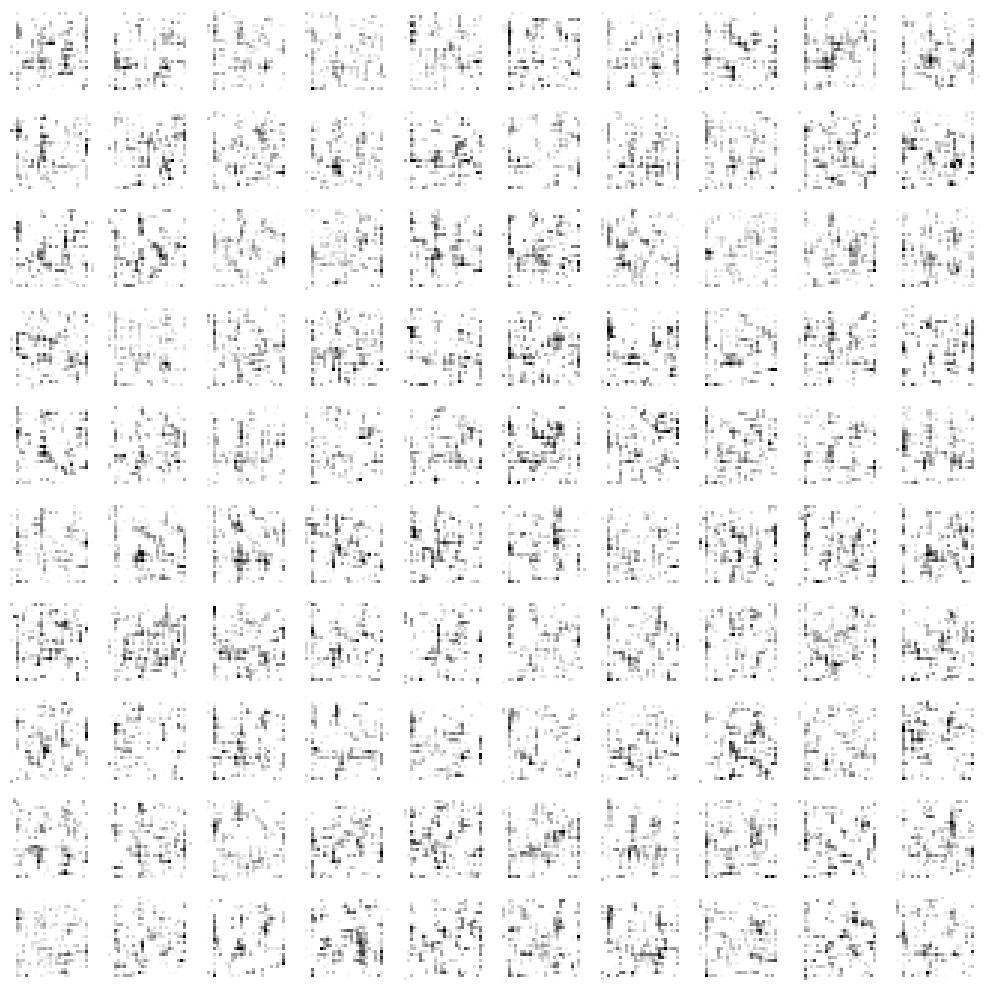

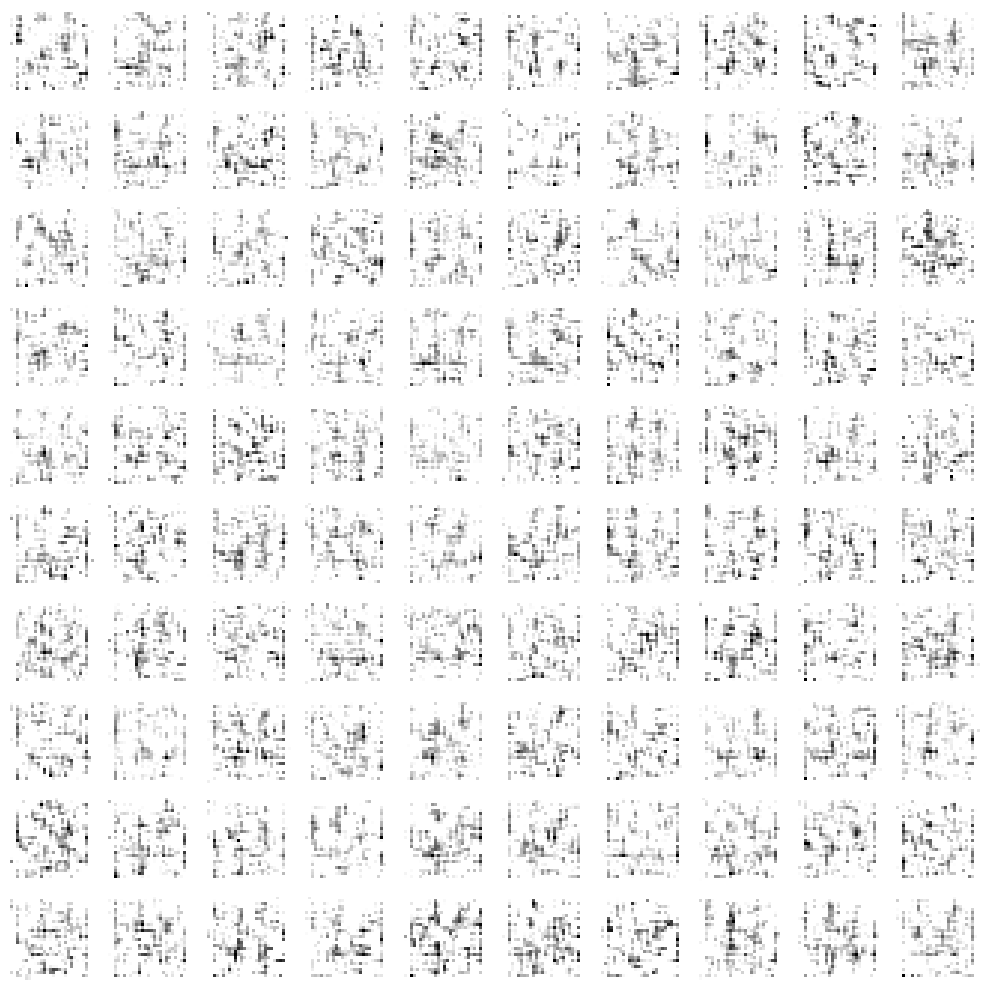

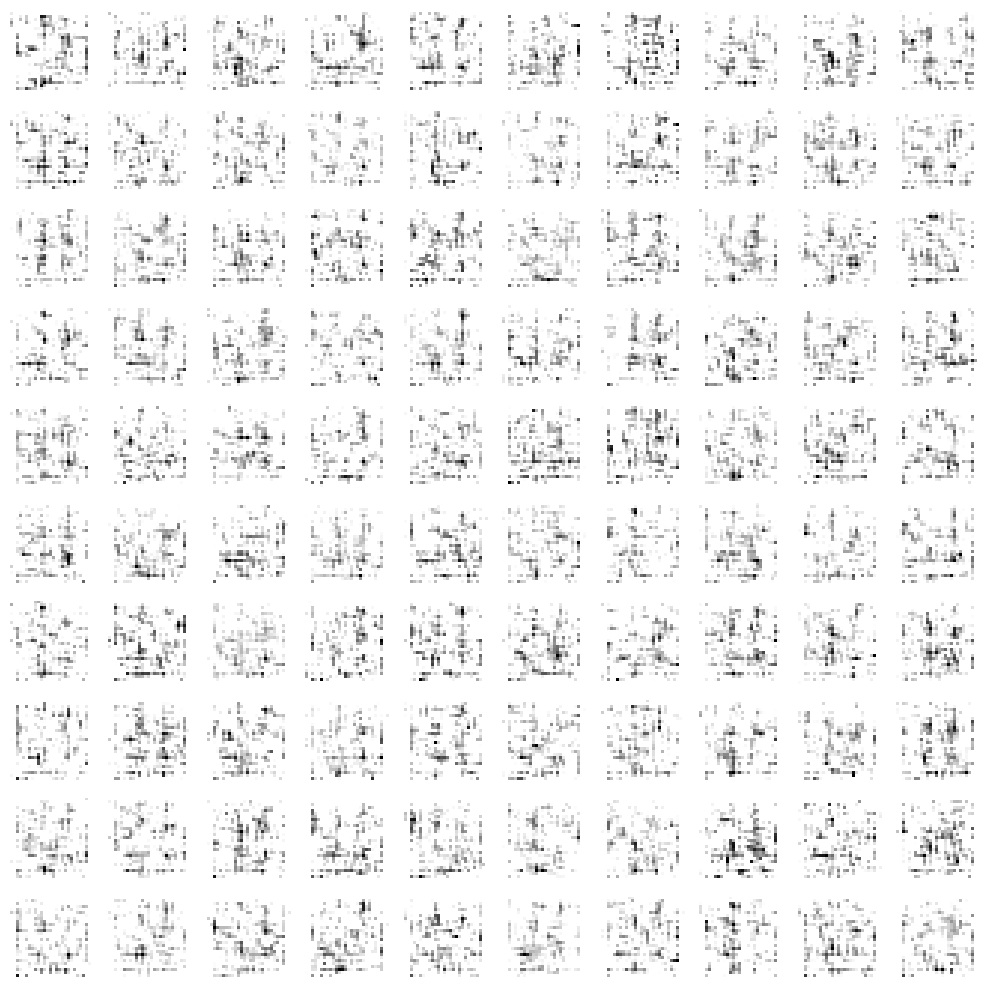

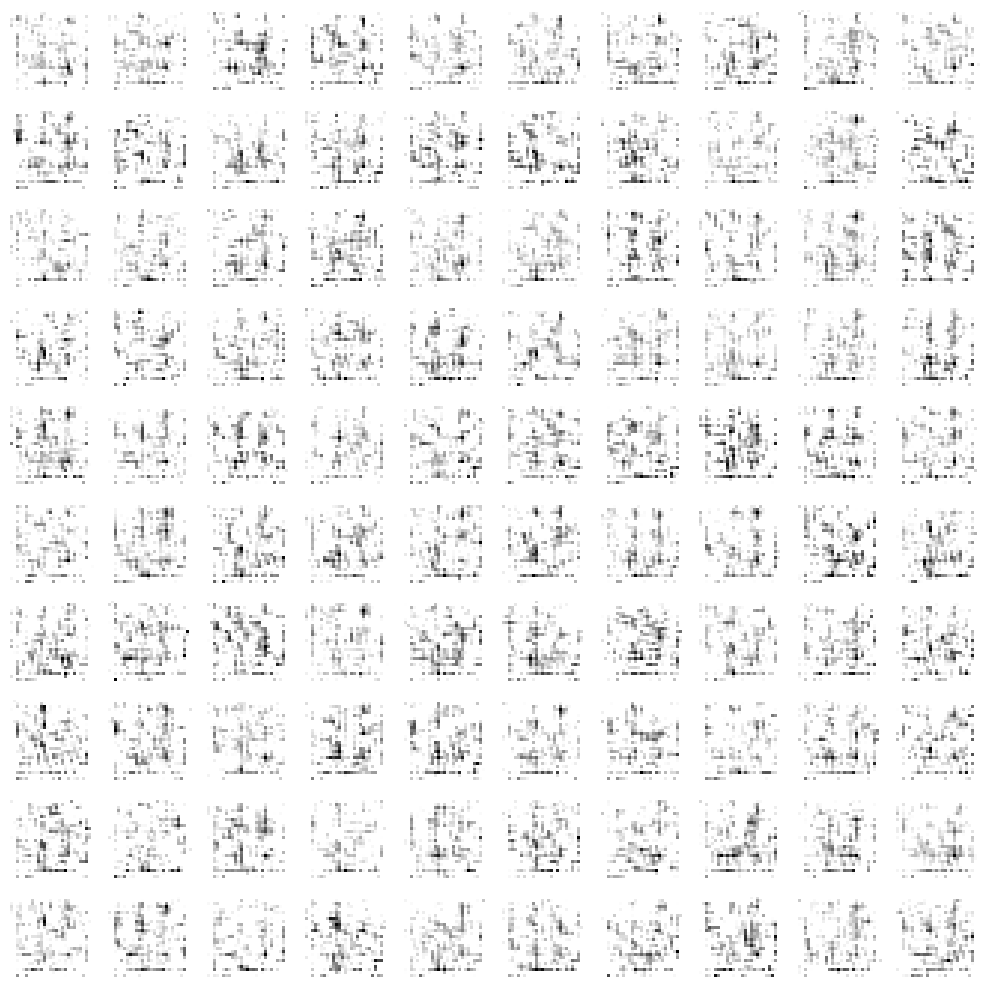

In [15]:
train(epochs=300, batch_size=64, save_interval=50)